## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной (0 или 1, а НЕ вероятность) для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### **Подключение библиотек и скриптов**

In [1]:
# импортирование стандартных библиотек машинного обучения, статистики, сохранения результатов и графического вывода
import numpy as np
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
import pickle
import gc # сборщик мусора
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# импортирование библиотек моделей
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

# импортирование библиотек для оптимизации моделей и оптимизации гиперпараметров
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# импортирование метрик и репортинга
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# убираем лишние замечания интерпретатора
import warnings
warnings.simplefilter('ignore')

# import additional packages for WOE/IV
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
# глобальные переменные WOE/IV
max_bin = 20
force_bin = 3

In [2]:
# функции метода WOE/IV

def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [3]:
# функция вывода результатов по основным метрикам

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color=['blue', 'green'], alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0],  
              label='Main class', color=['yellow', 'red'], alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))
    plt.show()

In [4]:
# функция вывода кривой обучения в зависимости от количества наблюдений в трейне

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

### **Пути к директориям и файлам**

In [5]:
# train dataset name
TRAIN_DATASET = '../course_project/course_project_train.csv'

# test dataset name
TEST_DATASET = '../course_project/course_project_test.csv'

### Загрузка данных и добавление столбца ID
<a class="anchor" id="load_data"></a>

In [6]:
X_train = pd.read_csv(TRAIN_DATASET)
X_train['ID'] = X_train.index.tolist()
X_test = pd.read_csv(TEST_DATASET)
X_test['ID'] = X_test.index.tolist()

## Обзор данных - EDA<a class="anchor" id="review"></a>

##### Сделаем наименование цели и сета базовых признаков

In [7]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = X_train.columns.drop(TARGET_NAME).tolist()

##### Корреляция цели с базовыми признаками

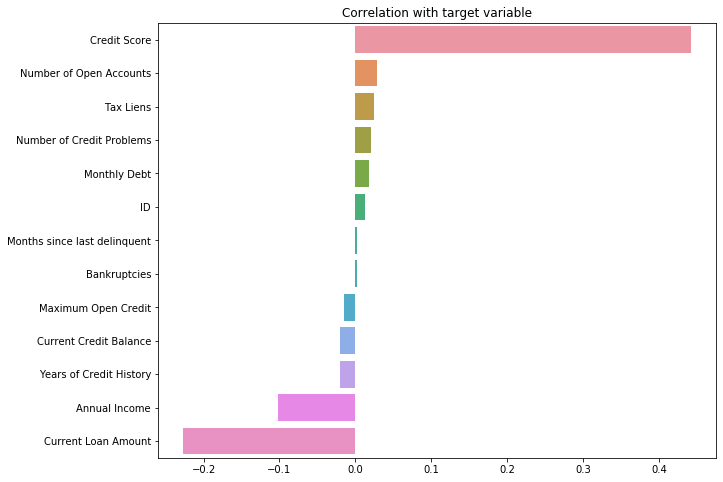

In [8]:
corr_with_target = X_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Вывод: сразу можно убрать из рассмотрения "Months since last delinquent" и "Bankruptcies" (пока не делаем)

### Оценка базовых признаков

##### Оценка признака "Annual Income" в разрезе целевой переменной

In [9]:
X = X_train.copy() # создаём копию для оценок
X = X.loc[~X['Annual Income'].isna()] # удаляем строки, где Annual Income пропущены

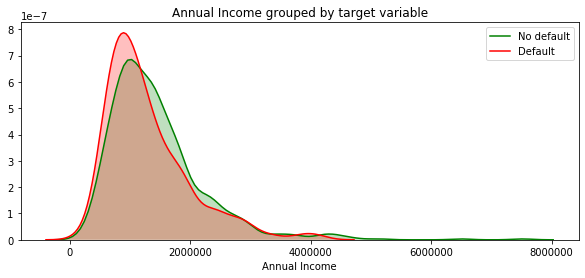

In [10]:
annual_income_with_target_s = X[['Annual Income', TARGET_NAME]].sample(1000)
annual_income_s = annual_income_with_target_s['Annual Income']
annual_income_target_0 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 0]
annual_income_target_1 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 4))

sns.kdeplot(annual_income_target_0, shade=True, label='No default', color='g')
sns.kdeplot(annual_income_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

Наблюдение:
Проверим имеются ли различия в распределениях, что может помочь при построение модели, т.к. это будет означать, что между признаком "Annual Income" и целевой переменной, возможно, существует некоторая функциональная зависимость.

Гипотеза:
Нулевая гипотеза: средние значения в двух независимых выборках равны
Альтернативная гипотеза: средние значения в двух независимых выборках различаются
Критерий: критерий Стьюдента (t-тест) и его аналоги
Уровень значимости  𝛼 : 0.05
Критическая область: двухсторонняя
Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений. Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

In [11]:
shapiro(annual_income_s)

(0.8519975543022156, 1.3921160296562262e-29)

Не "нормальное"распределение

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график

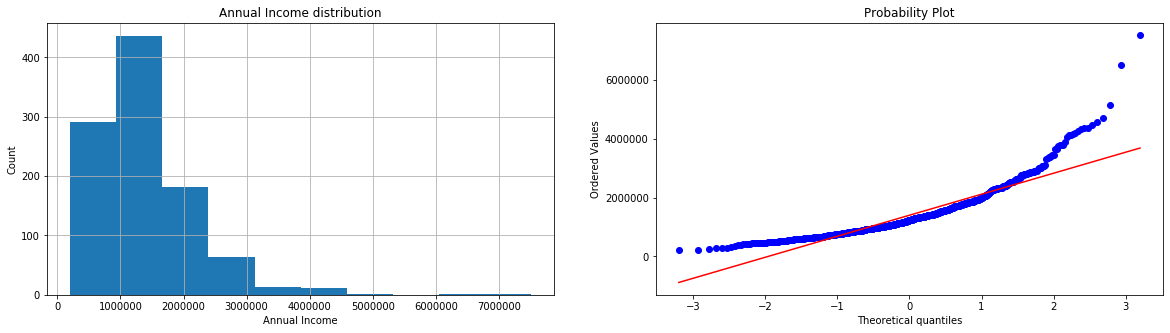

In [12]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
annual_income_s.hist()

plt.subplot(122)
probplot(annual_income_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Annual Income в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [13]:
mannwhitneyu(annual_income_target_0, annual_income_target_1)

MannwhitneyuResult(statistic=87673.5, pvalue=0.0009681360911592679)

Вероятность, что мат ожидания равны меньше 5%, следовательно нужно отвергать нулевую гипотезу

Дополнительно построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

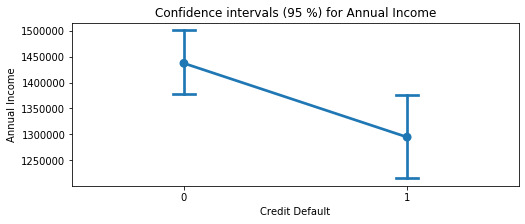

In [14]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_income_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.
Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения.

Т.о. оставляем признак в пуле фич для обучения

##### Оценка признака "Credit Score" в разрезе целевой переменной¶

In [15]:
del X
X = X_train.copy() # сoздаём новую копию для оценок
X = X.loc[~X['Credit Score'].isna()] # удаляем строки, где Credit Score пропущены

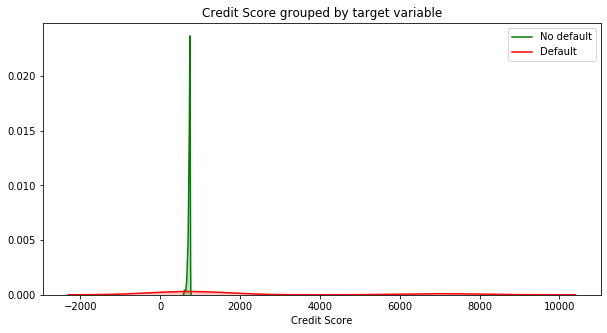

In [16]:
credit_score_with_target_s = X[['Credit Score', TARGET_NAME]].sample(1000)
credit_score_s = credit_score_with_target_s['Credit Score']
credit_score_target_0 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 0]
credit_score_target_1 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='No default', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

Есть выбросы, обработаем их, разделив на 10

In [17]:
X.loc[X['Credit Score'] > 1000, 'Credit Score'] = X.loc[X['Credit Score'] > 1000, 'Credit Score'] / 10

Ещё раз построим график

In [18]:
credit_score_with_target_s = X[['Credit Score', TARGET_NAME]].sample(5000)
credit_score_s = credit_score_with_target_s['Credit Score']
credit_score_target_0 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 0]
credit_score_target_1 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='No default', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

Наглядно видно, что распределение ненормальное и мат ожидания разные, но всё же проверим по критериям: Шапиро, QQ, Манна-Уитни и дов интервалам:

In [19]:
shapiro(credit_score_s)

(0.850967526435852, 0.0)

Не "нормальное" распределение

In [20]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score_s.hist()

plt.subplot(122)
probplot(credit_score_s, dist='norm', plot=plt)

plt.show()

Подтвердили "ненормальность"

In [21]:
mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=1784167.5, pvalue=1.9145032823309364e-52)

Мат ожидания равны с вероятность меньше 5% -> надо отвергать нулевую гипотезу

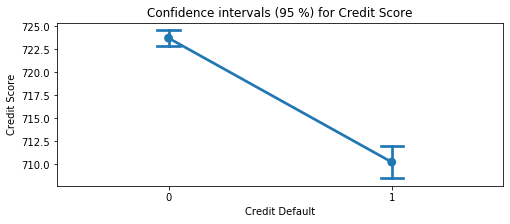

In [22]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

Т.о. оставляем фичу

##### Оценка признака "Current Loan Amount" в разрезе целевой переменной

In [23]:
del X
X = X_train.copy() # сoздаём новую копию для оценок
X = X.loc[~X['Current Loan Amount'].isna()] # удаляем строки, где Current Loan Amount пропущены

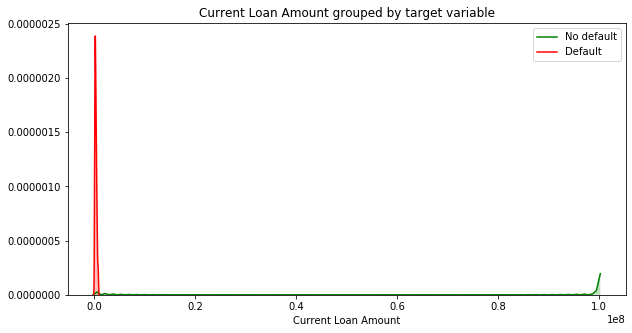

In [24]:
current_loan_amount_with_target_s = X[['Current Loan Amount', TARGET_NAME]].sample(1000)
current_loan_amount_s = current_loan_amount_with_target_s['Current Loan Amount']
current_loan_amount_target_0 = current_loan_amount_s[current_loan_amount_with_target_s[TARGET_NAME] == 0]
current_loan_amount_target_1 = current_loan_amount_s[current_loan_amount_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(current_loan_amount_target_0, shade=True, label='No default', color='g')
sns.kdeplot(current_loan_amount_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

Есть выбросы, особенно по недефолтным, нужно обработать, удалив:

In [25]:
X = X.loc[~X['Current Loan Amount'].isin([99999999])]

Ещё раз построим график:

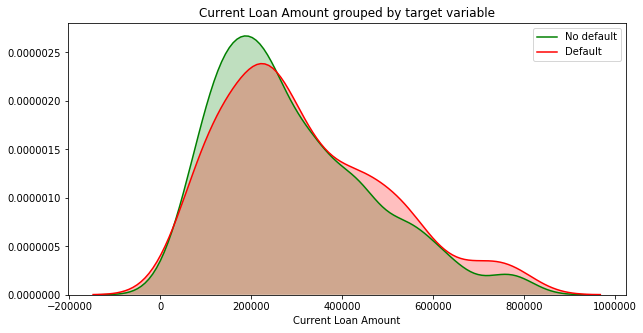

In [26]:
current_loan_amount_with_target_s = X[['Current Loan Amount', TARGET_NAME]].sample(1000)
current_loan_amount_s = current_loan_amount_with_target_s['Current Loan Amount']
current_loan_amount_target_0 = current_loan_amount_s[current_loan_amount_with_target_s[TARGET_NAME] == 0]
current_loan_amount_target_1 = current_loan_amount_s[current_loan_amount_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(current_loan_amount_target_0, shade=True, label='No default', color='g')
sns.kdeplot(current_loan_amount_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

проверим по критериям: Шапиро, QQ, Манна-Уитни и дов интервалам:

In [27]:
shapiro(current_loan_amount_s)

(0.939120888710022, 8.287030126210374e-20)

In [28]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
current_loan_amount_s.hist()

plt.subplot(122)
probplot(current_loan_amount_s, dist='norm', plot=plt)

plt.show()

In [29]:
mannwhitneyu(current_loan_amount_target_0, current_loan_amount_target_1)

MannwhitneyuResult(statistic=99299.5, pvalue=0.02890181966242144)

Мат ожидания равны с вероятность больше 5% -> нельзя отвергать нулевую гипотезу, смотрим дов. интервалы

In [30]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=current_loan_amount_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

Т.о. имеем все основания для отбраковки этой фичи, посмотрим на WOE/IV анализ

##### Оценка признака "Number of Open Accounts" в разрезе целевой переменной

In [31]:
del X
X = X_train.copy() # сoздаём новую копию для оценок

In [32]:
number_open_accounts_with_target_s = X[['Number of Open Accounts', TARGET_NAME]].sample(1000)
number_open_accounts_s = number_open_accounts_with_target_s['Number of Open Accounts']
number_open_accounts_target_0 = number_open_accounts_s[number_open_accounts_with_target_s[TARGET_NAME] == 0]
number_open_accounts_target_1 = number_open_accounts_s[number_open_accounts_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(number_open_accounts_target_0, shade=True, label='No default', color='g')
sns.kdeplot(number_open_accounts_target_1, shade=True, label='Default', color='r')

plt.xlabel('Number of Open Accounts')
plt.title('Number of Open Accounts grouped by target variable')
plt.show()

проверим по критериям: Шапиро, QQ, Манна-Уитни и дов интервалам:

In [33]:
shapiro(current_loan_amount_s)

(0.939120888710022, 8.287030126210374e-20)

In [34]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Number of Open Accounts')
ax1.set_ylabel('Count')
ax1.set_title('Number of Open Accounts distribution')
current_loan_amount_s.hist()

plt.subplot(122)
probplot(current_loan_amount_s, dist='norm', plot=plt)

plt.show()

вывод - не нормальное распределение

In [35]:
mannwhitneyu(current_loan_amount_target_0, current_loan_amount_target_1)

MannwhitneyuResult(statistic=99299.5, pvalue=0.02890181966242144)

Мат ожидания равны с вероятностью более 5% -> нельзя отвергать нулевую гипотезу, проверим дов. интервалы

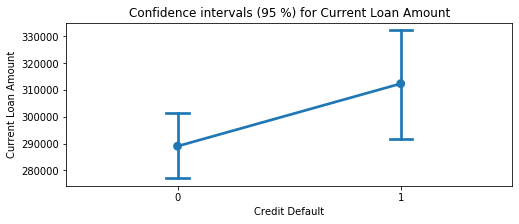

In [36]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=current_loan_amount_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

Т.о. получили доказательства для выбраковки фичи, решим после WOE/IV теста

##### Оценка признака "Tax Liens" в разрезе целевой переменной

In [37]:
del X
X = X_train.copy() # сoздаём новую копию для оценок

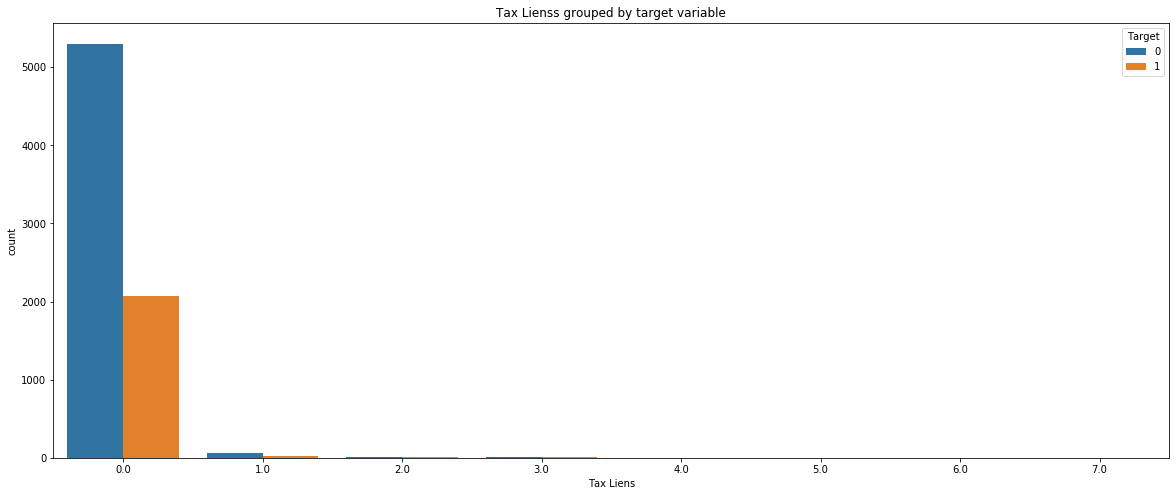

In [38]:
plt.figure(figsize=(20, 8))

sns.countplot(x="Tax Liens", hue=TARGET_NAME, data=X)
plt.title('Tax Lienss grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [39]:
tax_liens_and_target_s = X.loc[X['Tax Liens'].isin([0, 1]), ['ID', 'Tax Liens', TARGET_NAME]].sample(1000)

In [40]:
table = tax_liens_and_target_s.pivot_table(values='ID', index='Tax Liens', columns=TARGET_NAME, aggfunc='count')
table

Credit Default    0    1
Tax Liens               
0.0             707  281
1.0               5    7

In [41]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.02302966795133679

Т.о. нельзя отвергнуть нулевую гипотезу и можно объединить категории 0 и 1, остальные категории сложно оценивать - слишком мало данных, оставляем

##### Оценка признака "Years of Credit History" в разрезе целевой переменной

In [42]:
del X
X = X_train.copy() # сoздаём новую копию для оценок

In [43]:
years_credit_history_with_target_s = X[['Years of Credit History', TARGET_NAME]].sample(1000)
years_credit_history_s = years_credit_history_with_target_s['Years of Credit History']
years_credit_history_target_0 = years_credit_history_s[years_credit_history_with_target_s[TARGET_NAME] == 0]
years_credit_history_target_1 = years_credit_history_s[years_credit_history_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(years_credit_history_target_0, shade=True, label='No default', color='g')
sns.kdeplot(years_credit_history_target_1, shade=True, label='Default', color='r')

plt.xlabel('Years of Credit History')
plt.title('Years of Credit History grouped by target variable')
plt.show()

In [44]:
shapiro(years_credit_history_s)

(0.9503431916236877, 7.3641185054993e-18)

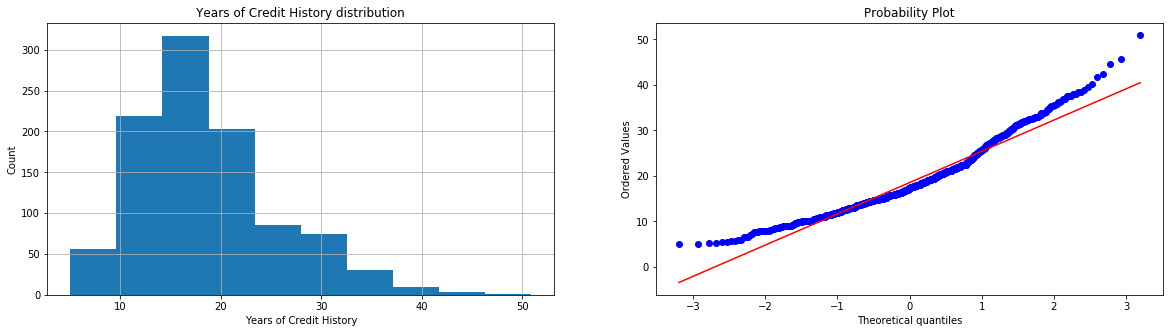

In [45]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Years of Credit History')
ax1.set_ylabel('Count')
ax1.set_title('Years of Credit History distribution')
years_credit_history_s.hist()

plt.subplot(122)
probplot(years_credit_history_s, dist='norm', plot=plt)

plt.show()

не нормальное распределение

In [46]:
mannwhitneyu(years_credit_history_target_0, years_credit_history_target_1)

MannwhitneyuResult(statistic=98906.5, pvalue=0.1906396207412533)

есть основание не отвергать нулевую гипотезу, т.к. получили результат больше 0.05, проверим дов. интервалы

In [47]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='Years of Credit History', data=years_credit_history_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Years of Credit History')
plt.show()

Т.о. доказали правомерность нулевой гипотезы и есть все основания отвергнуть фичу, ждём WOE теста

##### Оценка признака "Current Credit Balance" в разрезе целевой переменной

In [48]:
del X
X = X_train.copy() # сoздаём новую копию для оценок

In [49]:
current_credit_balance_with_target_s = X[['Current Credit Balance', TARGET_NAME]].sample(1000)
current_credit_balance_s = current_credit_balance_with_target_s['Current Credit Balance']
current_credit_balance_target_0 = current_credit_balance_s[current_credit_balance_with_target_s[TARGET_NAME] == 0]
current_credit_balance_target_1 = current_credit_balance_s[current_credit_balance_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(20, 5))

sns.kdeplot(current_credit_balance_target_0, shade=True, label='No default', color='g')
sns.kdeplot(current_credit_balance_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Credit Balance')
plt.title('Current Credit Balance grouped by target variable')
plt.show()

In [50]:
shapiro(current_credit_balance_s)

(0.6739993095397949, 5.0560810410689455e-40)

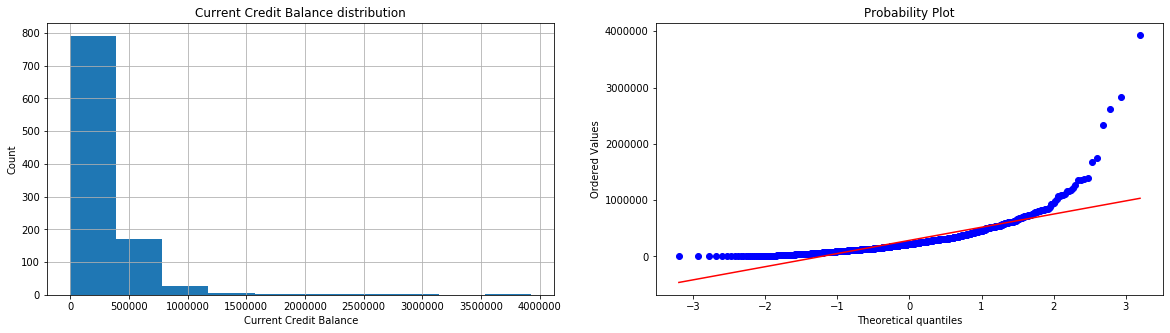

In [51]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Credit Balance')
ax1.set_ylabel('Count')
ax1.set_title('Current Credit Balance distribution')
current_credit_balance_s.hist()

plt.subplot(122)
probplot(current_credit_balance_s, dist='norm', plot=plt)

plt.show()

абсолютно не "нормальное" распределение - ярко выраженный эксцесс

In [52]:
mannwhitneyu(current_credit_balance_target_0, current_credit_balance_target_1)

MannwhitneyuResult(statistic=95457.5, pvalue=0.19120137090435751)

нет док-ва отвержения нулевой гипотезы, проверяем дов. интервалы, но результат сильно зависит от выборки, увеличивая размер выборки, увеличивается pvalue, следовательно наши рассуждения верны

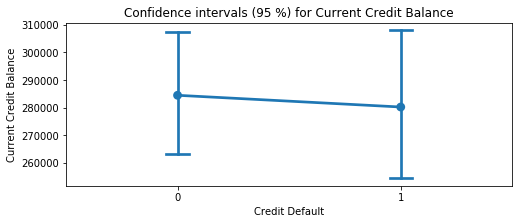

In [53]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='Current Credit Balance', data=current_credit_balance_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Credit Balance')
plt.show()

Т.о. мы имеем все доказательства для справедливости нулевой гипотезы и соответственно отброски этой фичи, ждём WOE

##### Оценка признака "Maximum Open Credit" в разрезе целевой переменной

In [54]:
del X
X = X_train.copy() # сoздаём новую копию для оценок

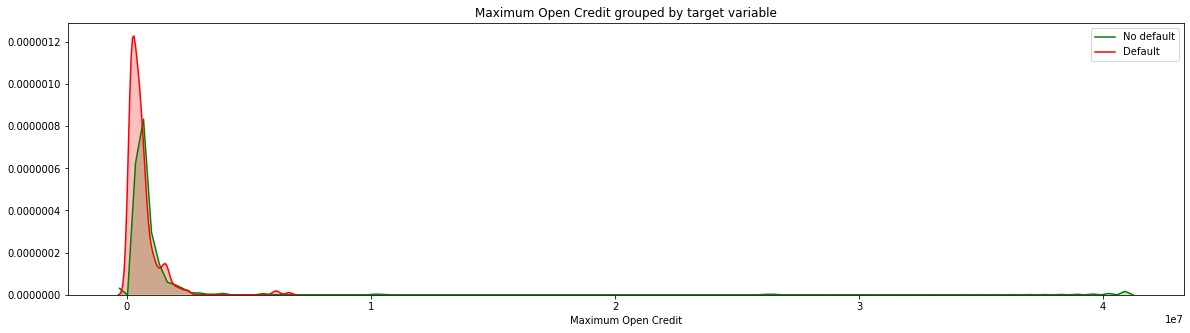

In [55]:
maximum_open_credit_with_target_s = X[['Maximum Open Credit', TARGET_NAME]].sample(1000)
maximum_open_credit_s = maximum_open_credit_with_target_s['Maximum Open Credit']
maximum_open_credit_target_0 = maximum_open_credit_s[maximum_open_credit_with_target_s[TARGET_NAME] == 0]
maximum_open_credit_target_1 = maximum_open_credit_s[maximum_open_credit_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(20, 5))

sns.kdeplot(maximum_open_credit_target_0, shade=True, label='No default', color='g')
sns.kdeplot(maximum_open_credit_target_1, shade=True, label='Default', color='r')

plt.xlabel('Maximum Open Credit')
plt.title('Maximum Open Credit grouped by target variable')
plt.show()

видим выбросы в нуле и высоких величинах, сильно зависит от выборки

In [56]:
shapiro(maximum_open_credit_s)

(0.186548113822937, 0.0)

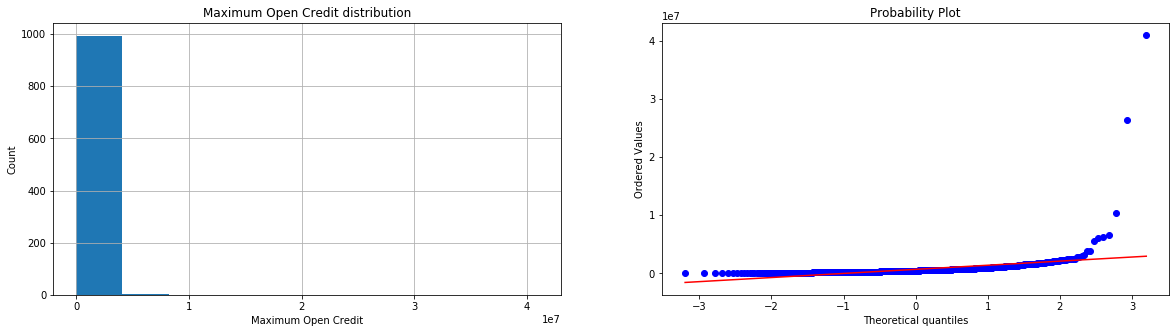

In [57]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Maximum Open Credit')
ax1.set_ylabel('Count')
ax1.set_title('Maximum Open Credit distribution')
maximum_open_credit_s.hist()

plt.subplot(122)
probplot(maximum_open_credit_s, dist='norm', plot=plt)

plt.show()

In [58]:
mannwhitneyu(maximum_open_credit_target_0, maximum_open_credit_target_1)

MannwhitneyuResult(statistic=97167.5, pvalue=0.011522165327723039)

результат сильно зависит от выборки(при 1000 экз.), при увеличении выборки, pvalue сильно падает, что толкает на отвержение нулевой гипотезы

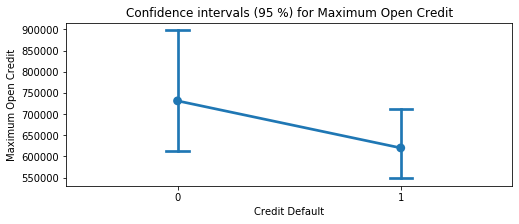

In [59]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='Maximum Open Credit', data=maximum_open_credit_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Maximum Open Credit')
plt.show()

Т.о. результаты сильно зависят от выборки, спорное состояние, решим позднее на методе WOE/IV

##### Оценка признака "Monthly Debt" в разрезе целевой переменной

In [60]:
del X
X = X_train.copy() # создаём копию для оценок

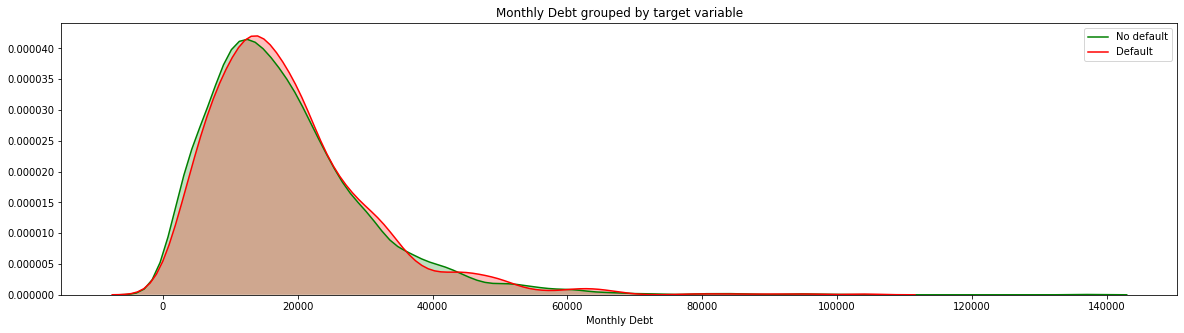

In [61]:
monthly_debt_with_target_s = X[['Monthly Debt', TARGET_NAME]].sample(5000)
monthly_debt_s = monthly_debt_with_target_s['Monthly Debt']
monthly_debt_target_0 = monthly_debt_s[monthly_debt_with_target_s[TARGET_NAME] == 0]
monthly_debt_target_1 = monthly_debt_s[monthly_debt_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(20, 5))

sns.kdeplot(monthly_debt_target_0, shade=True, label='No default', color='g')
sns.kdeplot(monthly_debt_target_1, shade=True, label='Default', color='r')

plt.xlabel('Monthly Debt')
plt.title('Monthly Debt grouped by target variable')
plt.show()

In [62]:
shapiro(monthly_debt_s)

(0.8857625126838684, 0.0)

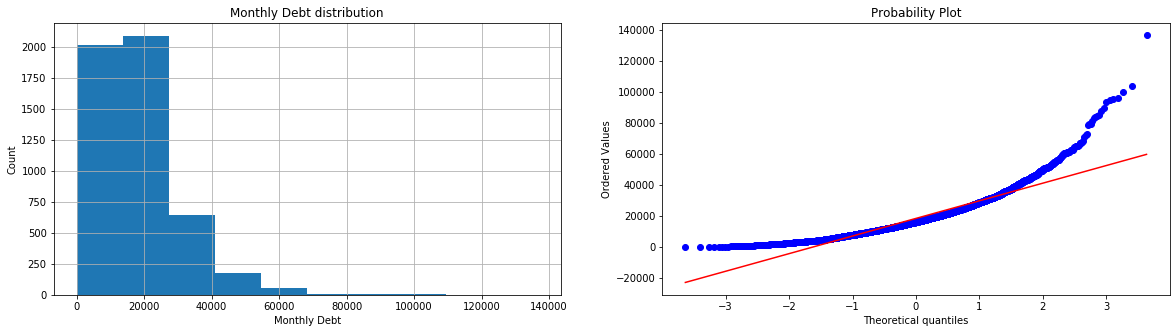

In [63]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Monthly Debt')
ax1.set_ylabel('Count')
ax1.set_title('Monthly Debt distribution')
monthly_debt_s.hist()

plt.subplot(122)
probplot(monthly_debt_s, dist='norm', plot=plt)

plt.show()

In [64]:
mannwhitneyu(monthly_debt_target_0, monthly_debt_target_1)

MannwhitneyuResult(statistic=2439686.5, pvalue=0.06195858554891292)

результаты сильно пляшут от выборки к выборке, приувеличении выборки до максимального pvalue < 0.05

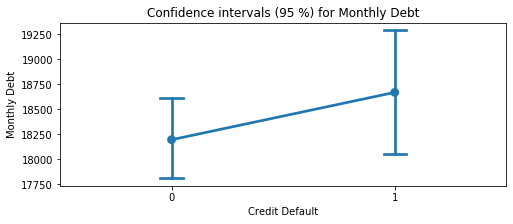

In [65]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='Monthly Debt', data=monthly_debt_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Monthly Debt')
plt.show()

Т.о. имеем спорное состояние, принимаем решение остваить фичу (позднее используем WOE/IV метод для решения)

##### Оценка признака "Number of Credit Problems" в разрезе целевой переменной

In [66]:
del X
X = X_train.copy() # создаём копию для оценок

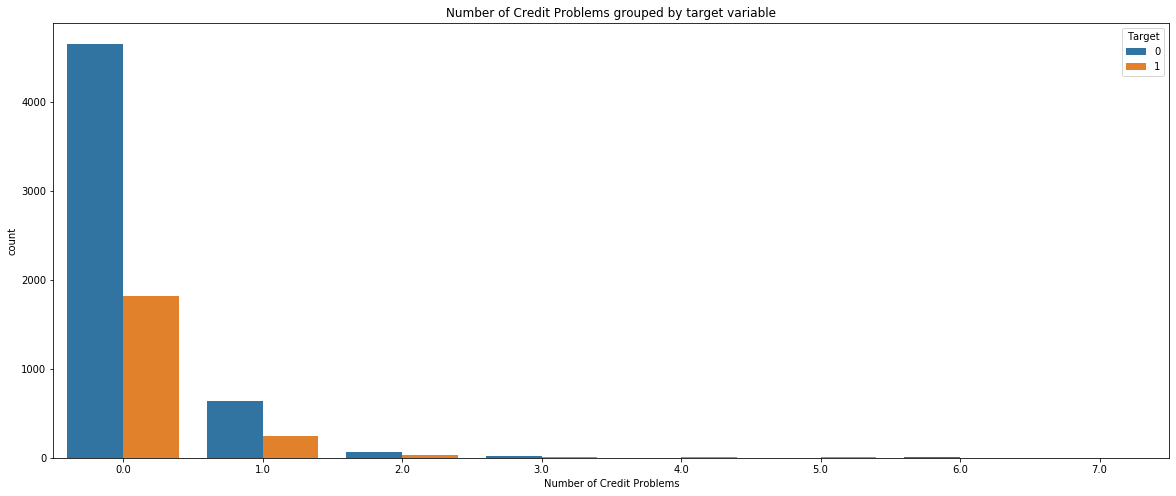

In [67]:
plt.figure(figsize=(20, 8))

sns.countplot(x="Number of Credit Problems", hue=TARGET_NAME, data=X)
plt.title('Number of Credit Problems grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [68]:
num_credit_problems_and_target_s = X.loc[X['Number of Credit Problems'].isin([0, 1, 2]), ['ID', 'Number of Credit Problems', TARGET_NAME]].sample(1000)

In [69]:
table = num_credit_problems_and_target_s.pivot_table(values='ID', index='Number of Credit Problems', columns=TARGET_NAME, aggfunc='count')
table

Credit Default               0    1
Number of Credit Problems          
0.0                        581  259
1.0                        103   41
2.0                          9    7

In [70]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.4440351657235645

Т.о. можно объединить категории 0, 1 и 2

#### Анализируем потенциально полезные новые фичи, производные от базовых

In [71]:
del X
X = X_train.copy()

In [72]:
X['max_open_credit_by_current_loan_amount'] = X['Maximum Open Credit'] / X['Current Loan Amount']

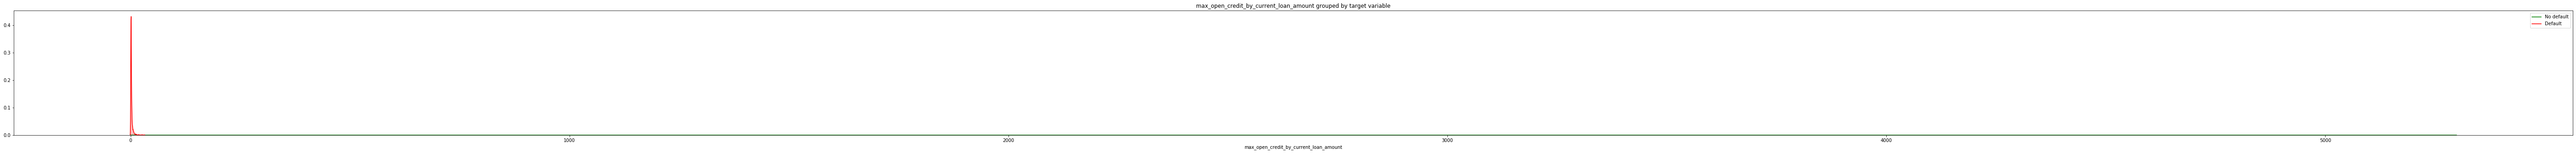

In [73]:
max_open_credit_by_current_loan_amount_with_target_s = X[['max_open_credit_by_current_loan_amount', TARGET_NAME]].sample(5000)
max_open_credit_by_current_loan_amount_s = max_open_credit_by_current_loan_amount_with_target_s['max_open_credit_by_current_loan_amount']
max_open_credit_by_current_loan_amount_target_0 = max_open_credit_by_current_loan_amount_s[max_open_credit_by_current_loan_amount_with_target_s[TARGET_NAME] == 0]
max_open_credit_by_current_loan_amount_target_1 = max_open_credit_by_current_loan_amount_s[max_open_credit_by_current_loan_amount_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(100, 5))

sns.kdeplot(max_open_credit_by_current_loan_amount_target_0, shade=True, label='No default', color='g')
sns.kdeplot(max_open_credit_by_current_loan_amount_target_1, shade=True, label='Default', color='r')

plt.xlabel('max_open_credit_by_current_loan_amount')
plt.title('max_open_credit_by_current_loan_amount grouped by target variable')
plt.show()

In [74]:
mannwhitneyu(max_open_credit_by_current_loan_amount_target_0, max_open_credit_by_current_loan_amount_target_1)

MannwhitneyuResult(statistic=2402656.5, pvalue=0.005978166617897339)

результаты сильно пляшут при выборке 1000 экз, при максимальном количестве экз, pvalue < 0.05

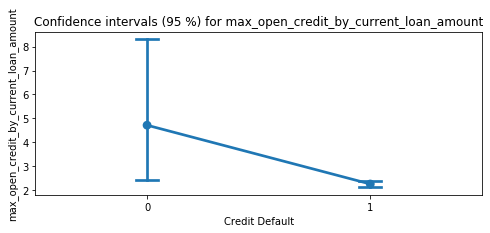

In [75]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='max_open_credit_by_current_loan_amount', data=max_open_credit_by_current_loan_amount_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for max_open_credit_by_current_loan_amount')
plt.show()

Т.о. можно оставить фичу

In [76]:
del X
X = X_train.copy()

In [77]:
X['annual_income_by_current_loan_amount'] = X['Annual Income'] / X['Current Loan Amount']

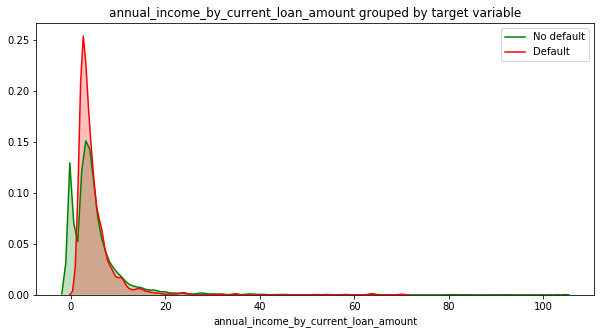

In [78]:
annual_income_by_current_loan_amount_with_target_s = X[['annual_income_by_current_loan_amount', TARGET_NAME]].sample(5000)
annual_income_by_current_loan_amount_s = annual_income_by_current_loan_amount_with_target_s['annual_income_by_current_loan_amount']
annual_income_by_current_loan_amount_target_0 = annual_income_by_current_loan_amount_s[annual_income_by_current_loan_amount_with_target_s[TARGET_NAME] == 0]
annual_income_by_current_loan_amount_target_1 = annual_income_by_current_loan_amount_s[annual_income_by_current_loan_amount_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_income_by_current_loan_amount_target_0, shade=True, label='No default', color='g')
sns.kdeplot(annual_income_by_current_loan_amount_target_1, shade=True, label='Default', color='r')

plt.xlabel('annual_income_by_current_loan_amount')
plt.title('annual_income_by_current_loan_amount grouped by target variable')
plt.show()

In [79]:
mannwhitneyu(annual_income_by_current_loan_amount_target_0, annual_income_by_current_loan_amount_target_1)

MannwhitneyuResult(statistic=2321518.5, pvalue=1.5321967118425655e-05)

сильные колебания pvalue при выборке 1000 экз, при увеличении до 5000 есть основание для отвержения нулевой гипотезы

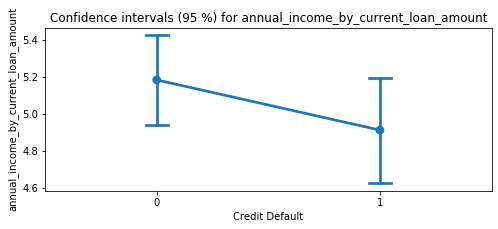

In [80]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='annual_income_by_current_loan_amount', data=annual_income_by_current_loan_amount_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for annual_income_by_current_loan_amount')
plt.show()

Т.о. спорная ситуация, пока оставляем фичу, решим по результатам WOE/IV

In [81]:
del X
X = X_train.copy()
X = X.loc[~X['Annual Income'].isna()] # удаляем строки, где Annual Income пропущены
X['monthly_debt_by_annual_income'] =X['Monthly Debt'] / X['Annual Income'] # создание фичи

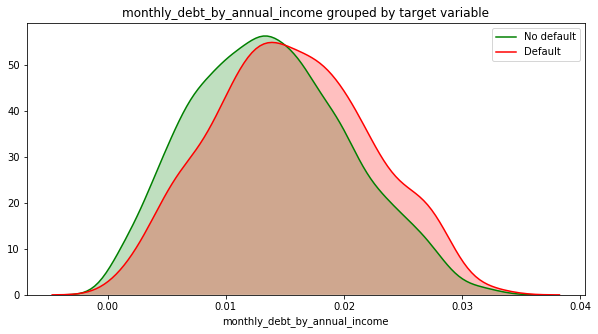

In [82]:
monthly_debt_by_annual_income_with_target_s = X[['monthly_debt_by_annual_income', TARGET_NAME]].sample(5000)
monthly_debt_by_annual_income_s = monthly_debt_by_annual_income_with_target_s['monthly_debt_by_annual_income']
monthly_debt_by_annual_income_target_0 = monthly_debt_by_annual_income_s[monthly_debt_by_annual_income_with_target_s[TARGET_NAME] == 0]
monthly_debt_by_annual_income_target_1 = monthly_debt_by_annual_income_s[monthly_debt_by_annual_income_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(monthly_debt_by_annual_income_target_0, shade=True, label='No default', color='g')
sns.kdeplot(monthly_debt_by_annual_income_target_1, shade=True, label='Default', color='r')

plt.xlabel('monthly_debt_by_annual_income')
plt.title('monthly_debt_by_annual_income grouped by target variable')
plt.show()

In [83]:
mannwhitneyu(monthly_debt_by_annual_income_target_0, monthly_debt_by_annual_income_target_1)

MannwhitneyuResult(statistic=2065761.5, pvalue=3.917587027615349e-17)

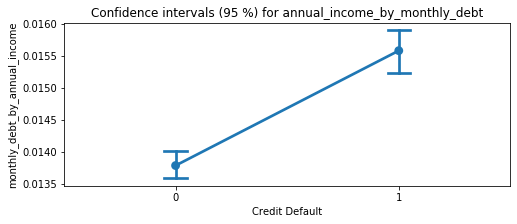

In [84]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='monthly_debt_by_annual_income', data=monthly_debt_by_annual_income_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for annual_income_by_monthly_debt')
plt.show()

Однозначно оставляем фичу

In [85]:
del X
X = X_train.copy()
X['monthly_debt_by_current_loan_amount'] = X['Monthly Debt'] / X['Current Loan Amount'] # создание фичи

In [86]:
monthly_debt_by_current_loan_amount_with_target_s = X[['monthly_debt_by_current_loan_amount', TARGET_NAME]].sample(1000)
monthly_debt_by_current_loan_amount_s = monthly_debt_by_current_loan_amount_with_target_s['monthly_debt_by_current_loan_amount']
monthly_debt_by_current_loan_amount_target_0 = monthly_debt_by_current_loan_amount_s[monthly_debt_by_current_loan_amount_with_target_s[TARGET_NAME] == 0]
monthly_debt_by_current_loan_amount_target_1 = monthly_debt_by_current_loan_amount_s[monthly_debt_by_current_loan_amount_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(monthly_debt_by_current_loan_amount_target_0, shade=True, label='No default', color='g')
sns.kdeplot(monthly_debt_by_current_loan_amount_target_1, shade=True, label='Default', color='r')

plt.xlabel('monthly_debt_by_current_loan_amount')
plt.title('monthly_debt_by_current_loan_amount grouped by target variable')
plt.show()

In [87]:
mannwhitneyu(monthly_debt_by_current_loan_amount_target_0, monthly_debt_by_current_loan_amount_target_1)

MannwhitneyuResult(statistic=87540.0, pvalue=0.0062430409648385)

опять колебания при 1000 экз, при увеличении до 5000 есть основание для отвержения нулевой гипотезы

In [88]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='monthly_debt_by_current_loan_amount', data=monthly_debt_by_current_loan_amount_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for monthly_debt_by_current_loan_amount')
plt.show()

спорно, но оставляем фичу

In [89]:
del X
X = X_train.copy()
X = X.loc[~X['Maximum Open Credit'].isin([0])]
X['monthly_debt_by_max_open_credit'] = X['Monthly Debt'] / X['Maximum Open Credit'] # создание фичи

In [90]:
monthly_debt_by_max_open_credit_with_target_s = X[['monthly_debt_by_max_open_credit', TARGET_NAME]].sample(1000)
monthly_debt_by_max_open_credit_s = monthly_debt_by_max_open_credit_with_target_s['monthly_debt_by_max_open_credit']
monthly_debt_by_max_open_credit_target_0 = monthly_debt_by_max_open_credit_s[monthly_debt_by_max_open_credit_with_target_s[TARGET_NAME] == 0]
monthly_debt_by_max_open_credit_target_1 = monthly_debt_by_max_open_credit_s[monthly_debt_by_max_open_credit_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(monthly_debt_by_max_open_credit_target_0, shade=True, label='No default', color='g')
sns.kdeplot(monthly_debt_by_max_open_credit_target_1, shade=True, label='Default', color='r')

plt.xlabel('monthly_debt_by_max_open_credit')
plt.title('monthly_debt_by_max_open_credit grouped by target variable')
plt.show()

In [91]:
mannwhitneyu(monthly_debt_by_max_open_credit_target_0, monthly_debt_by_max_open_credit_target_1)

MannwhitneyuResult(statistic=87289.0, pvalue=0.00011457218886321574)

при 1000 экз pvalue стабильно меньше 0.05, есть основание для отвержения нулевой гипотезы

In [92]:
plt.figure(figsize=(8, 3))

sns.pointplot(x=TARGET_NAME, y='monthly_debt_by_max_open_credit', data=monthly_debt_by_max_open_credit_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for monthly_debt_by_max_open_credit')
plt.show()

Спорно, но оставляем фичу

##### Проверка баланса классов цели

In [93]:
X_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

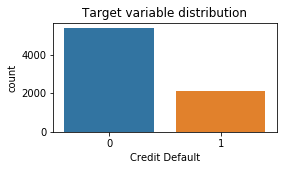

In [94]:
plt.figure(figsize=(4, 2))

sns.countplot(x=TARGET_NAME, data=X_train)

plt.title('Target variable distribution')
plt.show()

Вывод: нужно делать балансировку

##### **Создание цели и очистка мусора**

In [95]:
y_train = X_train[[TARGET_NAME]].copy()
y_train.head()

Credit Default
0               0
1               1
2               0
3               0
4               0

In [96]:
print('Строк в трейне:' ,  X_train.shape[0])
print('Строк в тесте', X_test.shape[0])

# Сборка и удаление мусора
del X
gc.collect()  

Строк в трейне: 7500
Строк в тесте 2500


7580

## Обработка пропусков и выбросов  и построение новых признаков по очистке<a class="anchor" id="outliers"></a>

In [97]:
len(X_train) - X_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
ID                                 0
dtype: int64

In [98]:
len(X_test) - X_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
ID                                 0
dtype: int64

In [99]:
# функция очистки фичей и генерации двух новых на основе присутствия ошибок в данных
def features_cleaning(X):
    
    X = X.copy()
    
    # Years in current job
    X.loc[X['Years in current job'].isna(), 'Years in current job'] = X['Years in current job'].mode()[0]

    # Maximum Open Credit
    X.loc[X['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = X['Maximum Open Credit'].median()

    # Credit Score
    X.loc[X['Credit Score'].isna(), 'Credit Score'] = X['Credit Score'].median()
    X['Credit Score outlier'] = 0
    X.loc[X['Credit Score'] >= 1000, 'Credit Score outlier'] = 1
    X.loc[X['Credit Score'] >= 1000, 'Credit Score'] = X.loc[X['Credit Score'] > 1000, 'Credit Score'] / 10

    # Months since last delinquent
    X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = X['Months since last delinquent'].median()
    
    #Bankruptcies
    X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = X['Bankruptcies'].median()
    
    # Current Loan Amount
    X['Current Loan Amount 9'] = 0
    X.loc[X['Current Loan Amount'] == 99999999, 'Current Loan Amount 9'] = 1
    X.loc[X['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = X['Current Loan Amount'].median()

    # Annual Income
    #X['Annual Income NaN'] = 1 - не делаем, практика показала бесполезность фичи
    #X.loc[X['Annual Income'].isna(), 'Annual Income NaN'] = 0 -  - не делаем, практика показала бесполезность фичи
    X.loc[X['Annual Income'].isna(), 'Annual Income'] = X['Annual Income'].median()
    
    return X

In [100]:
X_train = features_cleaning(X_train) # очистка трейна через функцию features_cleaning
X_test = features_cleaning(X_test) # очистка теста через функцию features_cleaning

### Создание новых признаков на основе анализа данных выше

In [101]:
X_train['max_open_credit_by_current_loan_amount'] = X_train['Maximum Open Credit'] / X_train['Current Loan Amount'] # создание фичи
X_train['annual_income_by_current_loan_amount'] = X_train['Annual Income'] / X_train['Current Loan Amount'] # создание фичи
X_train['monthly_debt_by_annual_income'] =X_train['Monthly Debt'] / X_train['Annual Income'] # создание фичи
X_train['monthly_debt_by_current_loan_amount'] = X_train['Monthly Debt'] / X_train['Current Loan Amount'] # создание фичи
X_train['monthly_debt_by_max_open_credit'] = X_train['Monthly Debt'] / X_train['Maximum Open Credit'] # создание фичи
X_test['max_open_credit_by_current_loan_amount'] = X_test['Maximum Open Credit'] / X_test['Current Loan Amount'] # создание фичи
X_test['annual_income_by_current_loan_amount'] = X_test['Annual Income'] / X_test['Current Loan Amount'] # создание фичи
X_test['monthly_debt_by_annual_income'] =X_test['Monthly Debt'] / X_test['Annual Income'] # создание фичи
X_test['monthly_debt_by_current_loan_amount'] = X_test['Monthly Debt'] / X_test['Current Loan Amount'] # создание фичи
X_test['monthly_debt_by_max_open_credit'] = X_test['Monthly Debt'] / X_test['Maximum Open Credit'] # создание фичи

In [102]:
len(X_train) - X_train.count()

Home Ownership                            0
Annual Income                             0
Years in current job                      0
Tax Liens                                 0
Number of Open Accounts                   0
Years of Credit History                   0
Maximum Open Credit                       0
Number of Credit Problems                 0
Months since last delinquent              0
Bankruptcies                              0
Purpose                                   0
Term                                      0
Current Loan Amount                       0
Current Credit Balance                    0
Monthly Debt                              0
Credit Score                              0
Credit Default                            0
ID                                        0
Credit Score outlier                      0
Current Loan Amount 9                     0
max_open_credit_by_current_loan_amount    0
annual_income_by_current_loan_amount      0
monthly_debt_by_annual_income   

In [103]:
len(X_test) - X_test.count()

Home Ownership                            0
Annual Income                             0
Years in current job                      0
Tax Liens                                 0
Number of Open Accounts                   0
Years of Credit History                   0
Maximum Open Credit                       0
Number of Credit Problems                 0
Months since last delinquent              0
Bankruptcies                              0
Purpose                                   0
Term                                      0
Current Loan Amount                       0
Current Credit Balance                    0
Monthly Debt                              0
Credit Score                              0
ID                                        0
Credit Score outlier                      0
Current Loan Amount 9                     0
max_open_credit_by_current_loan_amount    0
annual_income_by_current_loan_amount      0
monthly_debt_by_annual_income             0
monthly_debt_by_current_loan_amo

## Приведение переменных к нужным типам

###### Мапинг строковых фичей в трейне и тесте в int

In [104]:
X_train['Home Ownership'] = X_train['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1', 'Own Home':'2', 
                                                           'Have Mortgage':'3'}).astype(int)
X_train['Years in current job'] = X_train['Years in current job'].map({'10+ years':'0', '2 years':'1',
                                                                       '3 years':'2', '< 1 year':'3', '5 years':'4',
                                                                       '1 year':'5', '4 years':'6', '6 years':'7',
                                                                       '7 years':'8', '8 years':'9',
                                                                       '9 years':'10'}).astype(int)
X_train['Purpose'] = X_train['Purpose'].map({'debt consolidation':'0', 'other':'1', 'home improvements':'2',
                                             'business loan':'3', 'buy a car':'4', 'medical bills':'5',
                                             'major purchase':'6', 'take a trip':'7', 'buy house':'8',
                                             'small business':'9', 'wedding':'10', 'moving':'11',
                                             'educational expenses':'12', 'vacation':'13',
                                             'renewable energy':'14'}).astype(int)
X_train['Term'] = X_train['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

X_test['Home Ownership'] = X_test['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1', 'Own Home':'2', 
                                                           'Have Mortgage':'3'}).astype(int)
X_test['Years in current job'] = X_test['Years in current job'].map({'10+ years':'0', '2 years':'1',
                                                                       '3 years':'2', '< 1 year':'3', '5 years':'4',
                                                                       '1 year':'5', '4 years':'6', '6 years':'7',
                                                                       '7 years':'8', '8 years':'9',
                                                                       '9 years':'10'}).astype(int)
X_test['Purpose'] = X_test['Purpose'].map({'debt consolidation':'0', 'other':'1', 'home improvements':'2',
                                             'business loan':'3', 'buy a car':'4', 'medical bills':'5',
                                             'major purchase':'6', 'take a trip':'7', 'buy house':'8',
                                             'small business':'9', 'wedding':'10', 'moving':'11',
                                             'educational expenses':'12', 'vacation':'13',
                                             'renewable energy':'14'}).astype(int)
X_test['Term'] = X_test['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

##### Произведём оценку признаков по методике WOE/IV

In [105]:
final_iv, IV = data_vars(X_train, y_train['Credit Default']) # вычисление уровней IV (Information Values) метода WOE по фичам

In [106]:
IV.sort_values('IV') # вывод IV данных по фичам в отсортированном виде

VAR_NAME        IV
2                           Credit Default  0.000000
5                   Current Credit Balance  0.000021
18                    Years in current job  0.000147
8                           Home Ownership  0.000372
15                                 Purpose  0.000494
1                             Bankruptcies  0.000573
12            Months since last delinquent  0.000622
11                            Monthly Debt  0.000959
9                                       ID  0.001281
23     monthly_debt_by_current_loan_amount  0.002992
6                      Current Loan Amount  0.003440
13               Number of Credit Problems  0.004625
19                 Years of Credit History  0.004736
14                 Number of Open Accounts  0.004841
16                               Tax Liens  0.005232
10                     Maximum Open Credit  0.023023
7                    Current Loan Amount 9  0.028447
4                     Credit Score outlier  0.039728
24         monthly_debt_by_max_open_credit  0.044236
21  max_open_credit_by_current_loan_amount  0.059181
22           monthly_debt_by_annual_income  0.059580
0                            Annual Income  0.061166
20    annual_income_by_current_loan_amount  0.080513
17                                    Term  0.152956
3                             Credit Score  0.178463

Отбрасываем все фичи с IV параметром меньше 0.02 , как слабо информативных и бесполезных для обучения
несколько из них мы уже выбрали для удаления ранее: 'Months since last delinquent','Bankruptcies','Current Credit Balance',... по нескольким сомневались, сейчас удаляем

In [107]:
DROP_FEATURES = ['Number of Open Accounts', 'Years of Credit History', 'Monthly Debt', 'Months since last delinquent',
                 'Years in current job', 'ID', 'Home Ownership', 'Purpose', 'Number of Credit Problems',
                'Tax Liens', 'monthly_debt_by_current_loan_amount', 'Current Loan Amount', 'Bankruptcies',
                'Current Credit Balance', 'Bankruptcies', 'Months since last delinquent']

X_train = X_train.drop(DROP_FEATURES, axis=1)
X_test = X_test.drop(DROP_FEATURES, axis=1)

In [108]:
X_train = X_train.drop(TARGET_NAME, axis=1) # удаляем цель из трейна

In [109]:
X_train.dtypes

Annual Income                             float64
Maximum Open Credit                       float64
Term                                        int64
Credit Score                              float64
Credit Score outlier                        int64
Current Loan Amount 9                       int64
max_open_credit_by_current_loan_amount    float64
annual_income_by_current_loan_amount      float64
monthly_debt_by_annual_income             float64
monthly_debt_by_max_open_credit           float64
dtype: object

###### Нормализация признаков в обоих сетах

In [110]:
# сначала подготовим список фич для нормализации
FLOAT_FEATURE_NAMES = ['Annual Income', 'max_open_credit_by_current_loan_amount', 'annual_income_by_current_loan_amount',
                    'monthly_debt_by_annual_income', 'monthly_debt_by_max_open_credit',
                    'Current Loan Amount 9', 'Maximum Open Credit', 'Credit Score', 'Credit Score outlier', 'Term']

# теперь нормализуем
scaler = StandardScaler()

X_train_norm = X_train.copy()
X_train_norm[ FLOAT_FEATURE_NAMES] = scaler.fit_transform(X_train_norm[ FLOAT_FEATURE_NAMES])
X_test_norm = X_test.copy()
X_test_norm[ FLOAT_FEATURE_NAMES] = scaler.fit_transform(X_test_norm[ FLOAT_FEATURE_NAMES])

X_train = X_train_norm.copy()
X_test = X_test_norm.copy()

###### Посмотрим на всякий случай на данные, всё ли Ок

In [111]:
X_train.shape

(7500, 10)

In [112]:
X_train.head()

Annual Income  Maximum Open Credit      Term  Credit Score  \
0      -1.114304            -0.016433 -0.591517      1.054296   
1      -0.396190             0.014504  1.690569      0.579521   
2      -0.758385             0.014548 -0.591517      0.777344   
3      -0.687478            -0.050041 -0.591517     -1.121756   
4      -0.725543            -0.035161 -0.591517     -0.132642   

   Credit Score outlier  Current Loan Amount 9  \
0             -0.237356               2.760560   
1             -0.237356              -0.362245   
2             -0.237356               2.760560   
3             -0.237356              -0.362245   
4             -0.237356              -0.362245   

   max_open_credit_by_current_loan_amount  \
0                               -0.021127   
1                               -0.006046   
2                               -0.010349   
3                               -0.027858   
4                               -0.015413   

   annual_income_by_current_loan_amount  monthly_debt_by_annual_income  \
0                             -0.730880                       0.241065   
1                             -0.328814                       0.439554   
2                             -0.579649                       0.472731   
3                              0.151224                      -0.067581   
4                              0.070724                      -0.707123   

   monthly_debt_by_max_open_credit  
0                        -0.427283  
1                        -0.376840  
2                        -0.427186  
3                         0.395097  
4                        -0.338334

In [113]:
X_test.shape

(2500, 10)

In [114]:
X_test.head()

Annual Income  Maximum Open Credit      Term  Credit Score  \
0      -0.182442            -0.325833 -0.585973      0.362244   
1      -1.335526            -0.435058 -0.585973     -0.910631   
2      -0.214033            -0.336667 -0.585973      0.163358   
3      -0.131479            -0.170070 -0.585973      0.680463   
4       1.233554             0.326984  1.706565     -0.632189   

   Credit Score outlier  Current Loan Amount 9  \
0             -0.261488              -0.367173   
1             -0.261488              -0.367173   
2              3.824265              -0.367173   
3             -0.261488              -0.367173   
4             -0.261488              -0.367173   

   max_open_credit_by_current_loan_amount  \
0                               -0.172012   
1                               -0.241998   
2                               -0.208653   
3                               -0.091888   
4                               -0.151148   

   annual_income_by_current_loan_amount  monthly_debt_by_annual_income  \
0                              0.212384                      -1.195173   
1                             -0.423975                      -0.621765   
2                             -0.009383                       0.228299   
3                             -0.030715                       1.089446   
4                             -0.416654                       0.493395   

   monthly_debt_by_max_open_credit  
0                        -0.154002  
1                        -0.053314  
2                         0.422629  
3                         0.126813  
4                        -0.111659

### Разбиение обучающего датасета на "обучающий" - X_train_ и тестовый - X_test_, и целей, соответственно: y_train_, y_test_ (test_size берём по результатам анализа кривой обучения)

In [115]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, shuffle=True, test_size=0.57, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [116]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [117]:
df_for_balancing = pd.concat([X_train_, y_train_], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    2297
1    1856
Name: Credit Default, dtype: int64

In [118]:
X_train_ = df_balanced.drop(columns=TARGET_NAME)
y_train_ = df_balanced[TARGET_NAME]

### Сохранение полного обучающего, "обучающего" и "тестового" датасетов<a class="anchor" id="saving"></a>

In [119]:
train = pd.concat([X_train_, y_train_], axis=1)
test = pd.concat([X_test_, y_test_], axis=1)

In [120]:
X_train.to_csv('X_train_full_dataset.csv', index=False, encoding='utf-8')
train.to_csv('X_train_dataset.csv', index=False, encoding='utf-8')
test.to_csv('X_test_dataset.csv', index=False, encoding='utf-8')

### Создание и обучение моделей

##### Создание функции репортинга

In [121]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    #print('CONFUSION MATRIX\n')
    #print(pd.crosstab(y_test_true, y_test_pred))

In [122]:
model_lr = LogisticRegression(random_state=21)
model_lr.fit(X_train_, y_train_)

y_train_pred = model_lr.predict(X_train_)
y_test_pred = model_lr.predict(X_test_)

get_classification_report(y_train_, y_train_pred, y_test_, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.83      0.74      2297
           1       0.71      0.50      0.59      1856

    accuracy                           0.68      4153
   macro avg       0.69      0.67      0.67      4153
weighted avg       0.69      0.68      0.67      4153

TEST

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3090
           1       0.56      0.52      0.54      1185

    accuracy                           0.75      4275
   macro avg       0.69      0.68      0.68      4275
weighted avg       0.75      0.75      0.75      4275



In [123]:
show_learning_curve_plot(model_lr, X_train, y_train)

по графику видно, что ёмкость модели полностью вырабатывается после 3000 наблюдений,
т.о. имеет смысл уменьшить тренировочную выборку, используем test_size=0.57 при разбиение трейна (было ссделано выше)

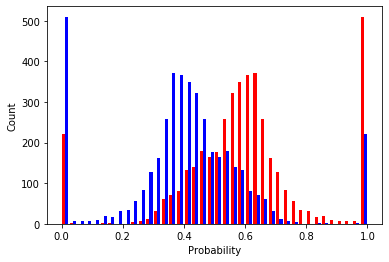

In [124]:
y_test_pred_proba = model_lr.predict_proba(X_test_)
plt.hist(y_test_pred_proba, bins =40, color=['red', 'blue'])
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()

In [125]:
show_proba_calibration_plots(y_test_pred_proba[:,-1], y_test_)

Т.о. выбираем Логистическую регрессию, т.к. хороший уровень метрики f1=0,539,
плюс простота и стабильность модели, неплохая решающая способность, минимальное переобучение ~ 8%

### Тюнинг и оценка выбранной модели - Logistic Regression

In [126]:
model_lr = LogisticRegression(random_state=21)

In [127]:
params = {'C':[0.1, 0.2, 0.5, 0.8, 0.9], 'penalty':['l1', 'l2', 'elasticnet', 'none']}

In [128]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [129]:
%%time

gs = GridSearchCV(model_lr, 
                  params, # параметры для оптимизации
                  scoring='f1', # метрика 
                  cv=cv, 
                  n_jobs=-1  # Кол-во потоков - все возможные
                  )
gs.fit(X_train_, y_train_)

CPU times: user 214 ms, sys: 36.3 ms, total: 250 ms
Wall time: 453 ms


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=LogisticRegression(random_state=21), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.5, 0.8, 0.9],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='f1')

In [130]:
gs.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [131]:
gs.best_score_

0.5786399598249264

In [132]:
model_lr = gs.best_estimator_

y_train_pred = model_lr.predict(X_train_)
y_test_pred = model_lr.predict(X_test_)

get_classification_report(y_train_, y_train_pred, y_test_, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.83      0.75      2297
           1       0.71      0.50      0.59      1856

    accuracy                           0.68      4153
   macro avg       0.69      0.67      0.67      4153
weighted avg       0.69      0.68      0.67      4153

TEST

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      3090
           1       0.56      0.51      0.54      1185

    accuracy                           0.75      4275
   macro avg       0.69      0.68      0.68      4275
weighted avg       0.75      0.75      0.75      4275



In [133]:
y_test_pred_proba = model_lr.predict_proba(X_test_)
plt.hist(y_test_pred_proba, bins =40, color=['red', 'blue'])
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()

In [134]:
show_proba_calibration_plots(y_test_pred_proba[:,-1], y_test_)

Получили лучшие метрики: f1 = 0.539, precision ~ 0.56, recall ~ 0.52, это удовлетворяет курсовому требованию
Переобучение по метрики f1 - в пределах допустимого задания: ((0.584 - 0.539)/0.565)*100% =~ 8%

## Финальная модель

In [135]:
model_final = model_lr

### Сохранение финальной модели

In [136]:
with open('SVaryukhin_solution.pkl', 'wb') as file:
    pickle.dump(model_final, file)

### Предсказание целей на тестовом датасете и сохранение и анализ результатов

In [137]:
y_test_full_pred = model_final.predict(X_test)

In [138]:
y_test_full_pred = pd.DataFrame(y_test_full_pred, columns=['Credit Default'])

In [139]:
y_test_full_pred.to_csv('SVaryukhin_solution.csv', sep=';')

In [140]:
y_test_full_pred['Credit Default'].value_counts(normalize=True)

0    0.7372
1    0.2628
Name: Credit Default, dtype: float64

In [141]:
plt.figure(figsize=(4, 2))

sns.countplot(x=TARGET_NAME, data=y_test_full_pred)

plt.title('Target variable distribution')
plt.show()

Вывод: пропорции предсказанных результатов немного отличаются от пропорций трейна, но считаем, что это допустимо

In [142]:
gc.collect() # удаление мусора

39301